# Pizza Sales Analysis Using SQL

In [2]:
# Imports
import pymysql
import pandas as pd

In [3]:
# Connecting to MySql Database
connection = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='Gothamhero1@1',
    database='pizza_sales'
)

cursor = connection.cursor()


**Tables Creation**

In [6]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS pizza_types (
    pizza_type_id VARCHAR(50) PRIMARY KEY,
    name VARCHAR(255),
    category VARCHAR(50),
    ingredients TEXT
)
""")

# Create pizza table with foreign key reference to pizza_types
cursor.execute("""
CREATE TABLE IF NOT EXISTS pizzas (
    pizza_id VARCHAR(50) PRIMARY KEY,
    pizza_type_id VARCHAR(50),
    size CHAR(5),
    price DECIMAL(5, 2),
    FOREIGN KEY (pizza_type_id) REFERENCES pizza_types(pizza_type_id)
)
""")

# Create orders table
cursor.execute("""
CREATE TABLE IF NOT EXISTS orders (
    order_id INT PRIMARY KEY,
    date DATE,
    time TIME
)
""")

# Create order_details table with foreign key references to orders and pizza
cursor.execute("""
CREATE TABLE IF NOT EXISTS order_details (
    order_details_id INT PRIMARY KEY,
    order_id INT,
    pizza_id VARCHAR(50),
    quantity INT,
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (pizza_id) REFERENCES pizzaS(pizza_id)
)
""")

0

Loading the data in to the database

In [7]:
pizza_df = pd.read_csv('C:\\Users\\SRINIVAS\\Downloads\\pizza_sales\\pizza_sales\\pizzas.csv')
pizza_types_df = pd.read_csv('C:\\Users\\SRINIVAS\\Downloads\\pizza_sales\\pizza_sales\\pizza_types.csv',encoding='Windows-1252')
orders_df = pd.read_csv('C:\\Users\\SRINIVAS\\Downloads\\pizza_sales\\pizza_sales\\orders.csv')
order_details_df = pd.read_csv('C:\\Users\\SRINIVAS\\Downloads\\pizza_sales\\pizza_sales\\order_details.csv')


def insert_data(df, table_name):
    cols = "`,`".join([str(i) for i in df.columns.tolist()])
    for i, row in df.iterrows():
        sql = "INSERT INTO `" + table_name + "` (`" + cols + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
        cursor.execute(sql, tuple(row))
        connection.commit()

# Insert data into tables
insert_data(pizza_types_df, 'pizza_types')
insert_data(pizza_df, 'pizzas')
insert_data(orders_df, 'orders')
insert_data(order_details_df, 'order_details')

print("Data inserted successfully.")

Data inserted successfully.


# Lets's Start Our Analysis

## Basic Analysis.

**1) First Let's see the total number of orders.**

In [4]:
cursor.execute('SELECT COUNT(order_id) AS total_orders FROM orders;')

# Fetch the result
count = cursor.fetchone()

# Print the total number of orders
print("The Total Number of Orders is", count[0])

The Total Number of Orders is 21350


**2)Analyzing the Hour-wise trend.**

In [5]:
cursor.execute("""SELECT HOUR(time) AS Hour, COUNT(order_id) AS Frequency 
               FROM orders 
               GROUP BY Hour 
               ORDER BY Frequency DESC;""")

# Fetch the results
results = cursor.fetchall()

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Hour', 'Frequency'])

# Print the DataFrame
print(df)

    Hour  Frequency
0     12       2520
1     13       2455
2     18       2399
3     17       2336
4     19       2009
5     16       1920
6     20       1642
7     14       1472
8     15       1468
9     11       1231
10    21       1198
11    22        663
12    23         28
13    10          8
14     9          1


From the above we can see that the frequency of the orders is more during the lunch time and the dinner time.

**3) Determination of Month-Wise Trend.**

In [6]:
cursor.execute("""SELECT MONTH(DATE) AS MONTH, COUNT(order_id) AS Frequency 
               FROM orders 
               GROUP BY MONTH 
               ORDER BY Frequency DESC;""")
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['Month', 'Frequency'])
print(df)

    Month  Frequency
0       7       1935
1       5       1853
2       1       1845
3       8       1841
4       3       1840
5       4       1799
6      11       1792
7       6       1773
8       2       1685
9      12       1680
10      9       1661
11     10       1646


We could see that the number of orders are more during the month of the july, so the store can provide promotional offers to further increase their sales.

**3) Let's See the Average number of Orders per Day**

In [7]:
cursor.execute("""SELECT AVG(quantity)
FROM (SELECT orders.date AS date, SUM(order_details.quantity) AS quantity
FROM orders
JOIN order_details ON orders.order_id = order_details.order_id
GROUP BY date) AS daily_quantities;""")
count = cursor.fetchone()
print("The Average Number of Pizza's Per Day is", count[0])

The Average Number of Pizza's Per Day is 138.4749


## Revenue Analysis

**4)Calculation of Total Revenue Earned.**

In [8]:
cursor.execute("""SELECT ROUND(SUM(order_details.quantity * pizzas.price),2) AS total_revenue
FROM order_details
JOIN pizzas
ON order_details.pizza_id = pizzas.pizza_id;""")
count = cursor.fetchone()
print("The Total Revenue is $", count[0])

The Total Revenue is $ 817860.05


**5) Determining the Top Pizza's based on the Revenue.**

In [9]:
cursor.execute("""SELECT pizza_types.name, SUM(order_details.quantity * pizzas.price) AS revenue
FROM pizza_types
JOIN pizzas ON pizza_types.pizza_type_id = pizzas.pizza_type_id
JOIN order_details ON order_details.pizza_id = pizzas.pizza_id
GROUP BY pizza_types.name
ORDER BY revenue DESC
LIMIT 3;""")
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['Pizza Type', 'Revenue'])
print(df)

                     Pizza Type   Revenue
0        The Thai Chicken Pizza  43434.25
1    The Barbecue Chicken Pizza  42768.00
2  The California Chicken Pizza  41409.50


**6) Contribution of Pizza Categories Towards Total Revenue.**

In [10]:
cursor.execute("""SELECT pizza_types.category, 
    SUM(order_details.quantity * pizzas.price) / (
        SELECT SUM(order_details.quantity * pizzas.price)
        FROM order_details 
        JOIN pizzas ON order_details.pizza_id = pizzas.pizza_id
    ) * 100 AS revenue_percentage
FROM pizza_types
JOIN pizzas ON pizza_types.pizza_type_id = pizzas.pizza_type_id
JOIN order_details ON order_details.pizza_id = pizzas.pizza_id
GROUP BY pizza_types.category
ORDER BY revenue_percentage DESC;""")
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['Pizza Category', 'Revenue(%)'])
print(df)

  Pizza Category Revenue(%)
0        Classic  26.905960
1        Supreme  25.456311
2        Chicken  23.955138
3         Veggie  23.682591


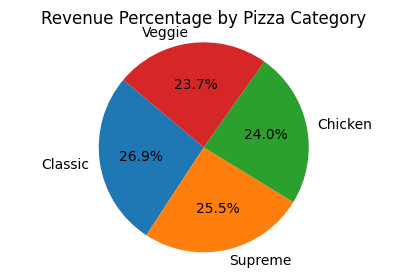

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.pie(df['Revenue(%)'], labels=df['Pizza Category'], autopct='%1.1f%%', startangle=140)
plt.title('Revenue Percentage by Pizza Category')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

## Pizza Preferences

**7) Identify the most common pizza size ordered.**

In [16]:
cursor.execute("""SELECT pizzas.size, COUNT(order_details.order_details_id) AS order_count
FROM pizzas
INNER JOIN order_details ON pizzas.pizza_id = order_details.pizza_id
GROUP BY pizzas.size
ORDER BY order_count DESC;""")
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['Pizza_Size', 'Number of Times Ordered'])
print(df)

  Pizza_Size  Number of Times Ordered
0          L                    18526
1          M                    15385
2          S                    14137
3         XL                      544
4        XXL                       28


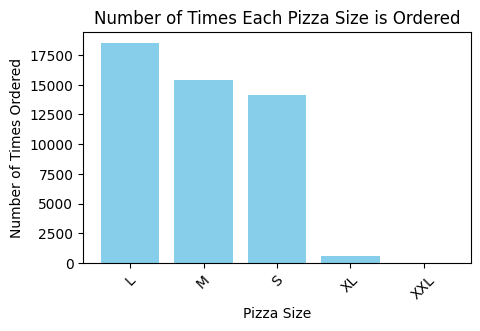

In [18]:
plt.figure(figsize=(5, 3))
plt.bar(df['Pizza_Size'], df['Number of Times Ordered'], color='skyblue')
plt.xlabel('Pizza Size')
plt.ylabel('Number of Times Ordered')
plt.title('Number of Times Each Pizza Size is Ordered')
plt.xticks(rotation=45)
plt.show()

From the Above we can see that the **Large** is the most ordered size. From this we can know to manage the inventory.

**8) Most Ordered Pizza and the Quantities** 

In [21]:
cursor.execute("""SELECT pizza_types.name, SUM(order_details.quantity) AS total_quantity_ordered
FROM pizza_types
INNER JOIN pizzas ON pizza_types.pizza_type_id = pizzas.pizza_type_id
INNER JOIN order_details ON order_details.pizza_id = pizzas.pizza_id
GROUP BY pizza_types.name
ORDER BY total_quantity_ordered DESC
LIMIT 5;""")
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['Pizza Type', 'Number of Times Ordered'])
print(df)

                   Pizza Type Number of Times Ordered
0    The Classic Deluxe Pizza                    2453
1  The Barbecue Chicken Pizza                    2432
2          The Hawaiian Pizza                    2422
3         The Pepperoni Pizza                    2418
4      The Thai Chicken Pizza                    2371


**9) Determing which Category of pizza is ordered Mostly.**

In [20]:
cursor.execute("""SELECT pizza_types.category, SUM(order_details.quantity)
FROM pizza_types
INNER JOIN pizzas ON pizza_types.pizza_type_id = pizzas.pizza_type_id
INNER JOIN order_details ON pizzas.pizza_id = pizzas.pizza_id
GROUP BY pizza_types.category
ORDER BY SUM(order_details.quantity) DESC;""")
results = cursor.fetchall()
df = pd.DataFrame(results, columns=['Pizza_Category', 'Number of Times Ordered'])
print(df)

  Pizza_Category Number of Times Ordered
0         Veggie                 1338498
1        Classic                 1288924
2        Supreme                 1239350
3        Chicken                  892332


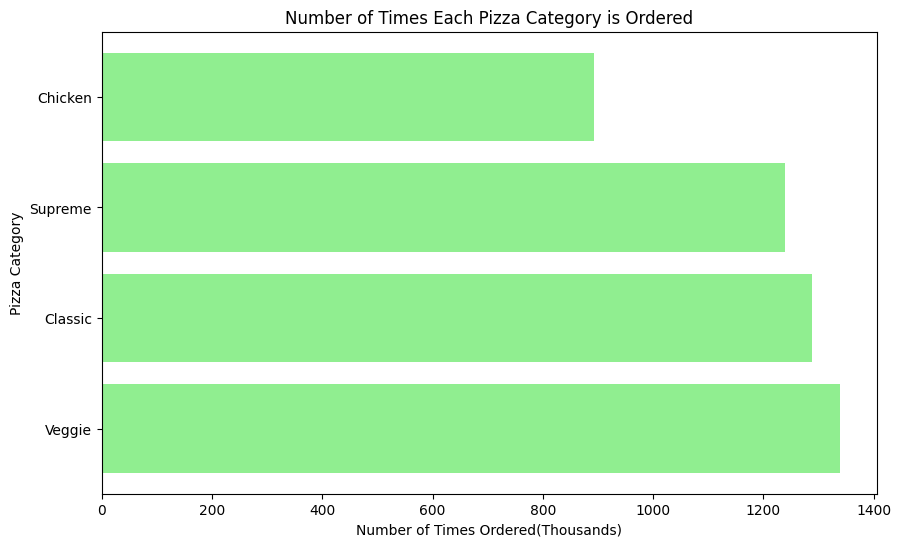

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(df['Pizza_Category'], df['Number of Times Ordered']/1000, color='lightgreen')
plt.xlabel('Number of Times Ordered(Thousands)')
plt.ylabel('Pizza Category')
plt.title('Number of Times Each Pizza Category is Ordered')
plt.show()

We could see that the Veggie Pizza is the most Ordered Pizza Category.